In [46]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset, WeightedRandomSampler
from torchvision import datasets
from torchvision import transforms
from copy import deepcopy
import torch.optim as optim

from tqdm.notebook import tqdm

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [47]:
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


drive.mount('/content/drive/')

df = pd.read_csv('/content/drive/My Drive/student_data.csv')
df

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,yes,yes,yes,yes,yes,yes,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,yes,no,yes,yes,no,no,4,3,2,1,2,5,4,6,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,MS,M,20,U,LE3,A,2,2,services,services,course,other,1,2,2,no,yes,yes,no,yes,yes,no,no,5,5,4,4,5,4,11,9,9,9
391,MS,M,17,U,LE3,T,3,1,services,services,course,mother,2,1,0,no,no,no,no,no,yes,yes,no,2,4,5,3,4,2,3,14,16,16
392,MS,M,21,R,GT3,T,1,1,other,other,course,other,1,1,3,no,no,no,no,no,yes,no,no,5,5,3,3,3,3,3,10,8,7
393,MS,M,18,R,LE3,T,3,2,services,other,course,mother,3,1,0,no,no,no,no,no,yes,yes,no,4,4,1,3,4,5,0,11,12,10


In [48]:
df.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'G3'],
      dtype='object')

In [49]:
df.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000
mean,16.696203,2.749367,2.521519,1.448101,2.035443,0.334177,3.944304,3.235443,3.108861,1.481013,2.291139,3.554430,5.708861,10.908861,10.713924,10.415190
std,1.276043,1.094735,1.088201,0.697505,0.839240,0.743651,0.896659,0.998862,1.113278,0.890741,1.287897,1.390303,8.003096,3.319195,3.761505,4.581443
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,3.000000,0.000000,0.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,3.000000,0.000000,8.000000,9.000000,8.000000
50%,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,4.000000,11.000000,11.000000,11.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,8.000000,13.000000,13.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,75.000000,19.000000,19.000000,20.000000


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 11  guardian    395 non-null    object
 12  traveltime  395 non-null    int64 
 13  studytime   395 non-null    int64 
 14  failures    395 non-null    int64 
 15  schoolsup   395 non-null    object
 16  famsup      395 non-null    object
 17  paid        395 non-null    object
 18  activities  395 non-null    object
 19  nursery     395 non-null    object
 20  higher    

In [51]:
df = df.drop_duplicates()
df.shape

(395, 33)

In [52]:
print('number of unique values in col :')
for c in df.columns:
    unique = df[c].nunique()
    if (unique <= 20):
        print('values: ',df[c].unique(),'-->   CATEGORICAL   -->     ', end='')
    print('"',c,'"','= ', unique)

number of unique values in col :
values:  ['GP' 'MS'] -->   CATEGORICAL   -->     " school " =  2
values:  ['F' 'M'] -->   CATEGORICAL   -->     " sex " =  2
values:  [18 17 15 16 19 22 20 21] -->   CATEGORICAL   -->     " age " =  8
values:  ['U' 'R'] -->   CATEGORICAL   -->     " address " =  2
values:  ['GT3' 'LE3'] -->   CATEGORICAL   -->     " famsize " =  2
values:  ['A' 'T'] -->   CATEGORICAL   -->     " Pstatus " =  2
values:  [4 1 3 2 0] -->   CATEGORICAL   -->     " Medu " =  5
values:  [4 1 2 3 0] -->   CATEGORICAL   -->     " Fedu " =  5
values:  ['at_home' 'health' 'other' 'services' 'teacher'] -->   CATEGORICAL   -->     " Mjob " =  5
values:  ['teacher' 'other' 'services' 'health' 'at_home'] -->   CATEGORICAL   -->     " Fjob " =  5
values:  ['course' 'other' 'home' 'reputation'] -->   CATEGORICAL   -->     " reason " =  4
values:  ['mother' 'father' 'other'] -->   CATEGORICAL   -->     " guardian " =  3
values:  [2 1 3 4] -->   CATEGORICAL   -->     " traveltime " =  4


In [53]:
sorted(df['absences'].unique())

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 28,
 30,
 38,
 40,
 54,
 56,
 75]

In [54]:
df.isna().sum()

school        0
sex           0
age           0
address       0
famsize       0
Pstatus       0
Medu          0
Fedu          0
Mjob          0
Fjob          0
reason        0
guardian      0
traveltime    0
studytime     0
failures      0
schoolsup     0
famsup        0
paid          0
activities    0
nursery       0
higher        0
internet      0
romantic      0
famrel        0
freetime      0
goout         0
Dalc          0
Walc          0
health        0
absences      0
G1            0
G2            0
G3            0
dtype: int64

In [55]:
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,yes,yes,yes,yes,yes,yes,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,yes,no,yes,yes,no,no,4,3,2,1,2,5,4,6,10,10


In [56]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [57]:
train_df

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
181,GP,M,16,U,GT3,T,3,3,services,other,home,mother,1,2,0,no,no,yes,yes,yes,yes,yes,yes,4,2,3,1,2,3,2,12,13,12
194,GP,M,16,U,GT3,T,2,3,other,other,home,father,2,1,0,no,no,no,no,yes,yes,yes,no,5,3,3,1,1,3,0,13,14,14
173,GP,F,16,U,GT3,T,1,3,at_home,services,home,mother,1,2,3,no,no,no,yes,no,yes,yes,yes,4,3,5,1,1,3,0,8,7,0
63,GP,F,16,U,GT3,T,4,3,teacher,health,home,mother,1,3,0,yes,yes,yes,yes,yes,yes,yes,no,3,4,4,2,4,4,2,10,9,9
253,GP,M,16,R,GT3,T,2,1,other,other,course,mother,2,1,0,no,no,no,yes,no,yes,no,no,3,3,2,1,3,3,0,8,9,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,GP,M,15,U,GT3,T,4,2,other,other,course,mother,1,4,0,no,no,no,no,yes,yes,yes,no,3,3,3,1,1,3,0,10,10,10
106,GP,F,15,U,GT3,T,2,2,other,other,course,mother,1,4,0,yes,yes,yes,no,yes,yes,yes,no,5,1,2,1,1,3,8,7,8,8
270,GP,F,19,U,GT3,T,3,3,other,services,home,other,1,2,2,no,yes,yes,yes,yes,yes,yes,no,4,3,5,3,3,5,15,9,9,9
348,GP,F,17,U,GT3,T,4,3,health,other,reputation,mother,1,3,0,no,yes,yes,yes,yes,yes,yes,yes,4,4,3,1,3,4,0,13,15,15


#encoding

In [58]:
train_df['school'] = train_df['school'].map({'GP': 0, 'MS': 1})
train_df['sex'] = train_df['sex'].map({'M': 0, 'F': 1})
train_df['address'] = train_df['address'].map({'R': 0, 'U': 1})
train_df['famsize'] = train_df['famsize'].map({'GT3': 0, 'LE3': 1})
train_df['Pstatus'] = train_df['Pstatus'].map({'A': 0, 'T': 1})
train_df['schoolsup'] = train_df['schoolsup'].map({'no': 0, 'yes': 1})
train_df['famsup'] = train_df['famsup'].map({'no': 0, 'yes': 1})
train_df['paid'] = train_df['paid'].map({'no': 0, 'yes': 1})
train_df['activities'] = train_df['activities'].map({'no': 0, 'yes': 1})
train_df['nursery'] = train_df['nursery'].map({'no': 0, 'yes': 1})
train_df['higher'] = train_df['higher'].map({'no': 0, 'yes': 1})
train_df['internet'] = train_df['internet'].map({'no': 0, 'yes': 1})
train_df['romantic'] = train_df['romantic'].map({'no': 0, 'yes': 1})


test_df['school'] = test_df['school'].map({'GP': 0, 'MS': 1})
test_df['sex'] = test_df['sex'].map({'M': 0, 'F': 1})
test_df['address'] = test_df['address'].map({'R': 0, 'U': 1})
test_df['famsize'] = test_df['famsize'].map({'GT3': 0, 'LE3': 1})
test_df['Pstatus'] = test_df['Pstatus'].map({'A': 0, 'T': 1})
test_df['schoolsup'] = test_df['schoolsup'].map({'no': 0, 'yes': 1})
test_df['famsup'] = test_df['famsup'].map({'no': 0, 'yes': 1})
test_df['paid'] = test_df['paid'].map({'no': 0, 'yes': 1})
test_df['activities'] = test_df['activities'].map({'no': 0, 'yes': 1})
test_df['nursery'] = test_df['nursery'].map({'no': 0, 'yes': 1})
test_df['higher'] = test_df['higher'].map({'no': 0, 'yes': 1})
test_df['internet'] = test_df['internet'].map({'no': 0, 'yes': 1})
test_df['romantic'] = test_df['romantic'].map({'no': 0, 'yes': 1})

In [59]:
pd.set_option('display.max_columns', 500)

In [60]:
train_df

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
181,0,0,16,1,0,1,3,3,services,other,home,mother,1,2,0,0,0,1,1,1,1,1,1,4,2,3,1,2,3,2,12,13,12
194,0,0,16,1,0,1,2,3,other,other,home,father,2,1,0,0,0,0,0,1,1,1,0,5,3,3,1,1,3,0,13,14,14
173,0,1,16,1,0,1,1,3,at_home,services,home,mother,1,2,3,0,0,0,1,0,1,1,1,4,3,5,1,1,3,0,8,7,0
63,0,1,16,1,0,1,4,3,teacher,health,home,mother,1,3,0,1,1,1,1,1,1,1,0,3,4,4,2,4,4,2,10,9,9
253,0,0,16,0,0,1,2,1,other,other,course,mother,2,1,0,0,0,0,1,0,1,0,0,3,3,2,1,3,3,0,8,9,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,0,0,15,1,0,1,4,2,other,other,course,mother,1,4,0,0,0,0,0,1,1,1,0,3,3,3,1,1,3,0,10,10,10
106,0,1,15,1,0,1,2,2,other,other,course,mother,1,4,0,1,1,1,0,1,1,1,0,5,1,2,1,1,3,8,7,8,8
270,0,1,19,1,0,1,3,3,other,services,home,other,1,2,2,0,1,1,1,1,1,1,0,4,3,5,3,3,5,15,9,9,9
348,0,1,17,1,0,1,4,3,health,other,reputation,mother,1,3,0,0,1,1,1,1,1,1,1,4,4,3,1,3,4,0,13,15,15


In [61]:
columns_to_encode = ['Mjob', 'Fjob', 'reason', 'guardian']

encoder = OneHotEncoder(handle_unknown='ignore')

encoder.fit(train_df[columns_to_encode])


encoded_train = encoder.transform(train_df[columns_to_encode])

encoded_test = encoder.transform(test_df[columns_to_encode])

In [62]:
encoded_train_df = pd.DataFrame(encoded_train.toarray(), columns=encoder.get_feature_names_out(columns_to_encode))
train_df_encoded = pd.concat([train_df.reset_index(drop=True), encoded_train_df.reset_index(drop=True)], axis=1)


encoded_test_df = pd.DataFrame(encoded_test.toarray(), columns=encoder.get_feature_names_out(columns_to_encode))
test_df_encoded = pd.concat([test_df.reset_index(drop=True), encoded_test_df.reset_index(drop=True)], axis=1)

In [63]:
test_df_encoded = test_df_encoded.drop(columns=columns_to_encode)
train_df_encoded = train_df_encoded.drop(columns=columns_to_encode)

In [64]:
train_df_encoded

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other
0,0,0,16,1,0,1,3,3,1,2,0,0,0,1,1,1,1,1,1,4,2,3,1,2,3,2,12,13,12,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0,0,16,1,0,1,2,3,2,1,0,0,0,0,0,1,1,1,0,5,3,3,1,1,3,0,13,14,14,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0,1,16,1,0,1,1,3,1,2,3,0,0,0,1,0,1,1,1,4,3,5,1,1,3,0,8,7,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0,1,16,1,0,1,4,3,1,3,0,1,1,1,1,1,1,1,0,3,4,4,2,4,4,2,10,9,9,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0,0,16,0,0,1,2,1,2,1,0,0,0,0,1,0,1,0,0,3,3,2,1,3,3,0,8,9,8,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311,0,0,15,1,0,1,4,2,1,4,0,0,0,0,0,1,1,1,0,3,3,3,1,1,3,0,10,10,10,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
312,0,1,15,1,0,1,2,2,1,4,0,1,1,1,0,1,1,1,0,5,1,2,1,1,3,8,7,8,8,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
313,0,1,19,1,0,1,3,3,1,2,2,0,1,1,1,1,1,1,0,4,3,5,3,3,5,15,9,9,9,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
314,0,1,17,1,0,1,4,3,1,3,0,0,1,1,1,1,1,1,1,4,4,3,1,3,4,0,13,15,15,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [65]:
columns_to_scale = ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health',
                    'absences']

scaler = MinMaxScaler()

scaler.fit(train_df_encoded[columns_to_scale])
train_df_encoded[columns_to_scale] = scaler.transform(train_df_encoded[columns_to_scale])

scaler.fit(test_df_encoded[columns_to_scale])
test_df_encoded[columns_to_scale] = scaler.transform(test_df_encoded[columns_to_scale])

In [66]:
train_df_encoded.head(3)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other
0,0,0,0.142857,1,0,1,0.75,0.75,0.000000,0.333333,0.0,0,0,1,1,1,1,1,1,0.75,0.25,0.5,0.0,0.25,0.5,0.026667,12,13,12,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0,0,0.142857,1,0,1,0.50,0.75,0.333333,0.000000,0.0,0,0,0,0,1,1,1,0,1.00,0.50,0.5,0.0,0.00,0.5,0.000000,13,14,14,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0,1,0.142857,1,0,1,0.25,0.75,0.000000,0.333333,1.0,0,0,0,1,0,1,1,1,0.75,0.50,1.0,0.0,0.00,0.5,0.000000,8,7,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [67]:
test_df_encoded.head(3)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other
0,0,0,0.4,1,0,1,0.50,0.25,0.333333,0.000000,1.000000,1,1,0,1,1,0,1,0,0.75,1.0,0.0,0.00,0.0,0.5,0.052632,8,8,10,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,1,0,0.6,0,1,1,0.25,0.50,0.666667,0.000000,0.000000,0,1,1,1,1,0,1,1,0.75,0.5,0.5,0.25,0.5,0.5,0.078947,14,12,12,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0,0,0.6,0,1,1,0.75,0.75,0.000000,0.333333,0.333333,0,1,0,0,1,1,1,1,0.75,0.5,0.5,0.00,0.5,1.0,0.210526,3,5,5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


#model

In [68]:
#train_df_encoded['GPA'] = (train_df_encoded['G1'] + train_df_encoded['G2'] + train_df_encoded['G3'])/3
#test_df_encoded['GPA'] = (test_df_encoded['G1'] + test_df_encoded['G2'] + test_df_encoded['G3'])/3

In [69]:
#train_df_encoded = train_df_encoded.drop(columns=['G1', 'G2', 'G3'])
#test_df_encoded = test_df_encoded.drop(columns=['G1', 'G2', 'G3'])

In [70]:
train_X = train_df_encoded.drop(columns=['G3'])
train_y = train_df_encoded['G3']

test_X = test_df_encoded.drop(columns=['G3'])
test_y = test_df_encoded['G3']

(array([33.,  0.,  4., 17., 49., 87., 52., 44., 15., 15.]),
 array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20.]),
 <BarContainer object of 10 artists>)

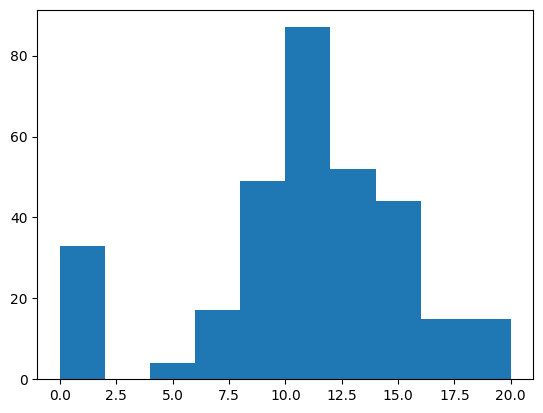

In [71]:
plt.hist(train_y)

In [72]:
#avg_train_y = train_y.mean()
#std_train_y = train_y.std()

In [73]:
#train_y = (train_y - avg_train_y)/std_train_y

In [74]:
#plt.hist(train_y)

In [75]:
X_train = torch.from_numpy(train_X.values)
y_train = torch.tensor(train_y.values).view(-1, 1)

X_test = torch.from_numpy(test_X.values)
y_test = torch.tensor(test_y.values).view(-1, 1)

In [76]:
X_train = X_train.to(torch.float32)
y_train = y_train.to(torch.float32)
X_test = X_test.to(torch.float32)
y_test = y_test.to(torch.float32)

In [77]:
trainset = TensorDataset(X_train, y_train)
testset = TensorDataset(X_test, y_test)

testloader = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

In [78]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, activation, dropout_rate=0.0):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.activation = activation
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out = self.fc1(x)
        out = self.activation(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.activation(out)
        out = self.dropout(out)
        out = self.fc3(out)
        return out

# Set the hyperparameters
input_dim = X_train.shape[1]
hidden_dim = 64
output_dim = 1
learning_rate = 0.01
num_epochs = 20
dropout_rate = 0.2
weight_decay = 0.001
activation = nn.ReLU()

In [87]:
def evaluate(net, dataloader):
    net.eval()
    total_loss = 0
    total_samples = 0
    total_predicted = []
    total_labels = []
    r2=[]
    losses=[]
    with torch.no_grad():
        for data in dataloader:
            features, labels = data
            outputs = net(features)
            loss = F.mse_loss(outputs, labels)

            r2.append(r2_score(labels, outputs))
            total_loss += loss.item()
            losses.append(loss.item())
            total_samples += labels.size(0)

            total_predicted.extend(outputs.view(-1).tolist())
            total_labels.extend(labels.view(-1).tolist())


    print(r2)
    plt.plot(losses)
    plt.show()
    mse = total_loss / total_samples
    mae = mean_absolute_error(total_labels, total_predicted)
    r2 = r2_score(total_labels, total_predicted)

    return mse, mae, r2


def train_it(optimizer, trainloader, model, criterion, num_epochs, l1=0.0):
  losses=[]
  for epoch in range(num_epochs):
      running_loss = 0.0
      for i, data in enumerate(trainloader, 0):
          inputs, labels = data
          optimizer.zero_grad()
          outputs = model(inputs)
          loss = criterion(outputs, labels)

          if(l1 != 0):
            l1_lambda = l1
            l1_norm = sum(torch.linalg.norm(p, 1) for p in model.parameters())

            loss = loss + l1_lambda * l1_norm


          loss.backward()
          optimizer.step()
          running_loss += loss.item()
      if((epoch+1)%10==0):
        print(f"Epoch {epoch+1} - Training loss: {running_loss/len(trainloader)}")
      losses.append(running_loss/len(trainloader))

  plt.plot(losses)
  plt.show()

In [88]:

def define_priority_abs(model, dataset, batch_size):
    model.eval()
    losses = torch.tensor([])
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    with torch.no_grad():
        for data_inputs, data_labels in data_loader:
            preds = model(data_inputs)
            loss = (torch.abs(preds-data_labels))
            losses = torch.cat((losses, loss),dim=0)
        losses = (losses/losses.sum()).squeeze(1)
        return WeightedRandomSampler(losses.tolist(), len(losses))

def train_model(model, optimizer, data_set, batch_size, loss_module, num_epochs, th=5):
    model.train()
    t_losses = []
    pbar = tqdm(range(num_epochs))
    for epoch in pbar:
        if epoch%th == 0:
            sampler = define_priority_abs(model, data_set, batch_size)
            data_loader = DataLoader(data_set,batch_size=batch_size,sampler=sampler)
        losses = 0
        for (data_inputs, data_labels) in data_loader:

            preds = model(data_inputs)

            loss = loss_module(preds, data_labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses += loss.item()
        e = losses/len(data_loader)
        t_losses.append(e)
        pbar.set_description(f"Epoch {epoch+1} the training loss is : {e}")
    plt.plot(t_losses)
    plt.show()
    return model, t_losses

Epoch 10 - Training loss: 5.687895965576172
Epoch 20 - Training loss: 4.793624353408814


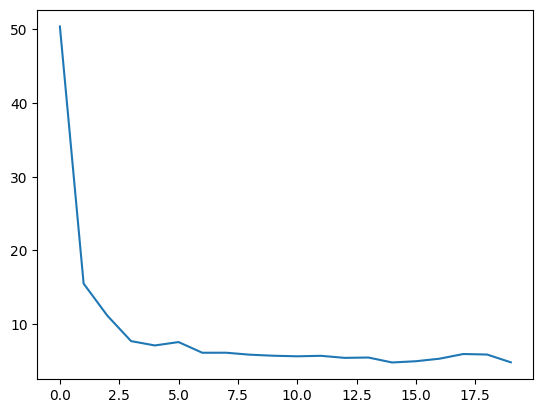

[0.5198248308589393, 0.6312012920746808, 0.8939823020918831, 0.3571651851454576, 0.8292141221475425]


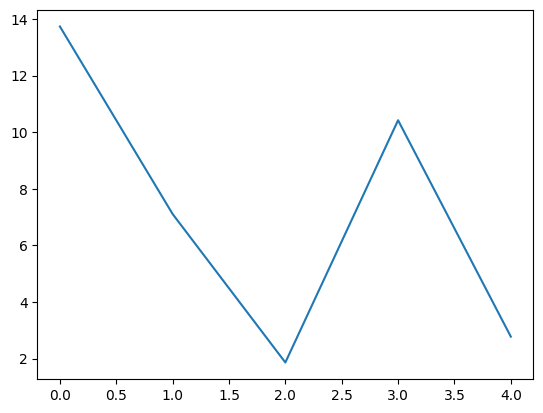

MSE, MAE and R2: (0.4545194966883599, 1.7253317401001724, 0.6470535308012274)


In [89]:
net = MLP(input_dim, hidden_dim, output_dim, activation, dropout_rate)
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

train_it(optimizer, trainloader, net, criterion, num_epochs)

print(f"MSE, MAE and R2: {evaluate(net, testloader)}")

Epoch 10 - Training loss: 3.213341403007507
Epoch 20 - Training loss: 1.8931501626968383


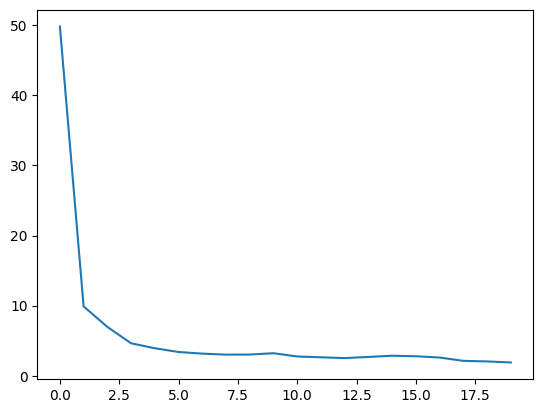

[0.5547976536973533, 0.656908348447041, 0.7281929361507418, 0.33073906300253364, 0.5325381606346176]


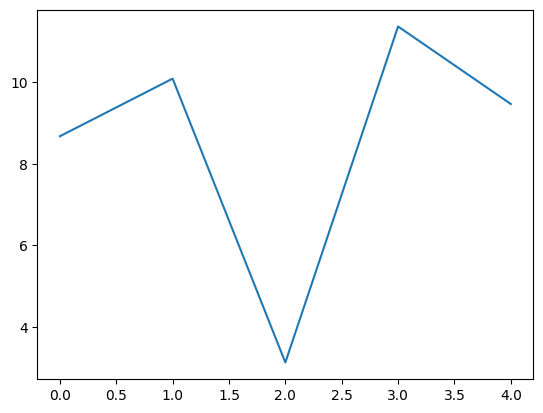

MSE, MAE and R2: (0.540766196914866, 1.8841545504482486, 0.5838857802601887)


In [103]:
net = MLP(input_dim, hidden_dim, output_dim, activation, 0.0)
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

train_it(optimizer, trainloader, net, criterion, num_epochs= 20)

print(f"MSE, MAE and R2: {evaluate(net, testloader)}")

# 2

Epoch 10 - Training loss: 5.6450108051300045
Epoch 20 - Training loss: 4.521071219444275


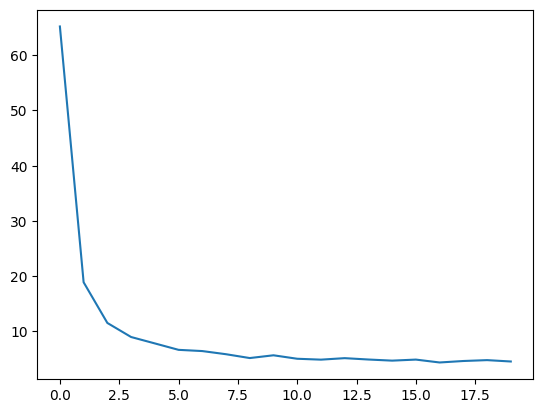

[0.8008043295765326, 0.6471548857179746, 0.6309325457026331, 0.841859631937293, 0.6375603388602437]


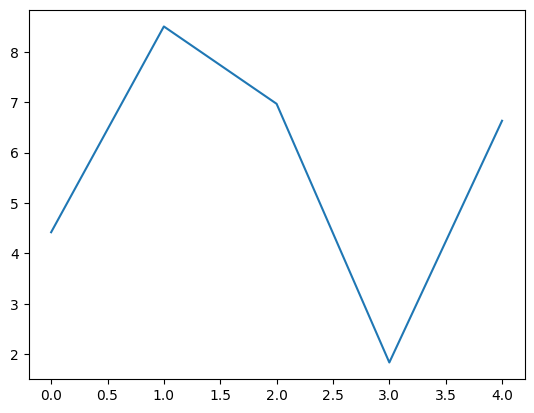

MSE, MAE and R2 : (0.35887527616718146, 1.5388676486437833, 0.7240641484276846)


In [90]:
class MLP2(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, activation, dropout_rate=0.0):
        super(MLP2, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.activation = activation
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out = self.fc1(x)
        out = self.activation(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out


net = MLP2(input_dim, hidden_dim, output_dim, activation, dropout_rate)
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

train_it(optimizer, trainloader, net, criterion, num_epochs)


print(f"MSE, MAE and R2 : {evaluate(net, testloader)}")

# 3

Epoch 10 - Training loss: 4.1510565161705015
Epoch 20 - Training loss: 2.7288878321647645


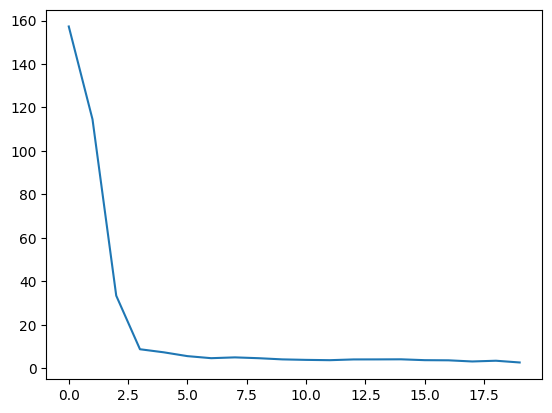

[0.5833084276217753, 0.3053938497031461, 0.7164027706590658, 0.317420906447745, 0.455131704166414]


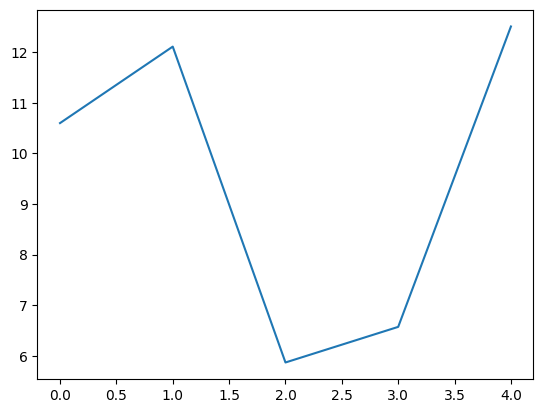

MSE, MAE and R2 : (0.6032606981977632, 2.4278277369522594, 0.5370010705511543)


In [91]:
class MLP3(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, activation, dropout_rate=0.0):
        super(MLP3, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.activation = activation
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_dim, 2*hidden_dim)
        self.fc3 = nn.Linear(2*hidden_dim, 2*hidden_dim)
        self.fc4 = nn.Linear(2*hidden_dim, 2*hidden_dim)
        self.fc5 = nn.Linear(2*hidden_dim, hidden_dim)
        self.fc6 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out = self.fc1(x)
        out = self.activation(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.activation(out)
        out = self.fc3(out)
        out = self.activation(out)
        out = self.fc4(out)
        out = self.activation(out)
        out = self.fc5(out)
        out = self.activation(out)
        out = self.fc6(out)
        return out


net_adam = MLP3(input_dim, hidden_dim, output_dim, activation, dropout_rate)
criterion = nn.MSELoss()
optimizer_adam = optim.Adam(net_adam.parameters(), lr=learning_rate)
train_it(optimizer_adam, trainloader, net_adam, criterion, num_epochs)
print(f"MSE, MAE and R2 : {evaluate(net_adam, testloader)}")

#4

Epoch 10 - Training loss: 2.9019208192825316
Epoch 20 - Training loss: 3.2716427564620973


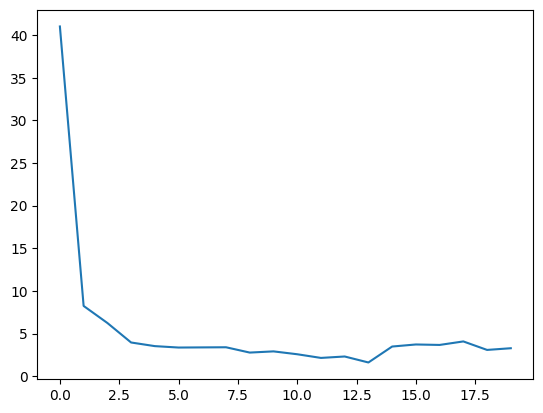

[0.5303496156466063, 0.7480579822811833, 0.7116378446977748, 0.5224170377484405, 0.5379557794371538]


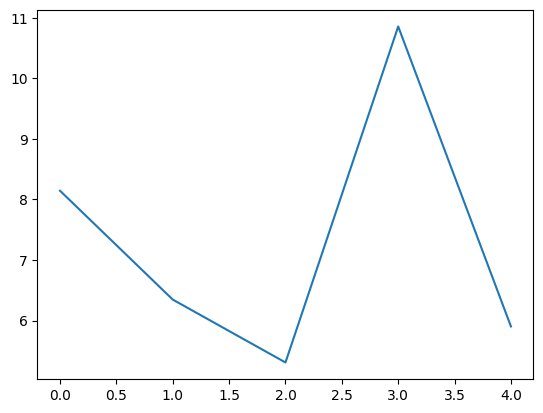

MSE, MAE and R2 : (0.46272641797608965, 2.180417344416197, 0.6425799002945406)


In [92]:
net_adam = MLP3(input_dim, hidden_dim, output_dim, activation, dropout_rate= 0)
criterion = nn.MSELoss()
optimizer_adam = optim.Adam(net_adam.parameters(), lr=learning_rate)

train_it(optimizer_adam, trainloader, net_adam, criterion, num_epochs)
print(f"MSE, MAE and R2 : {evaluate(net_adam, testloader)}")

#  L1

Epoch 10 - Training loss: 2.533527445793152
Epoch 20 - Training loss: 1.5401300728321075


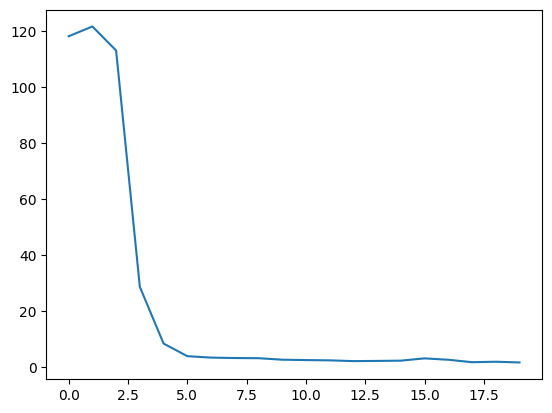

[0.5869902419596507, 0.857957348530224, 0.66398307441719, 0.6982425145122837, 0.32637954671028413]


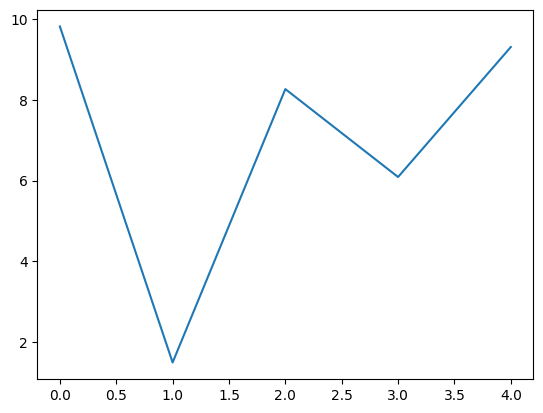

MSE, MAE and R2 : (0.4428639985338042, 1.6944343738163574, 0.6601829843499014)


In [110]:
#without l1
net_adam = MLP3(input_dim, hidden_dim, output_dim, activation, dropout_rate= 0)
criterion = nn.MSELoss()
optimizer_adam = optim.Adam(net_adam.parameters(), lr=learning_rate)

train_it(optimizer_adam, trainloader, net_adam, criterion, 20)

print(f"MSE, MAE and R2 : {evaluate(net_adam, testloader)}")

Epoch 10 - Training loss: 17.00711441040039
Epoch 20 - Training loss: 13.454068756103515


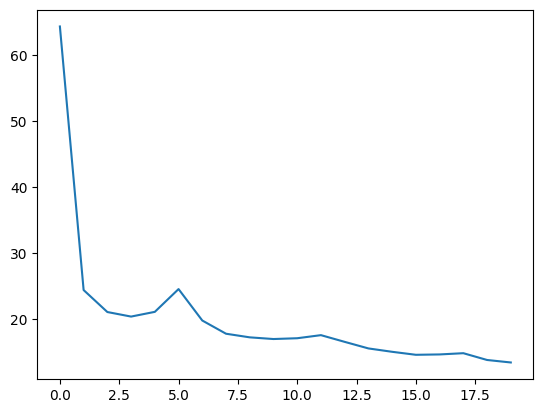

[0.6784443272696528, 0.7540252594324752, 0.8680583731825741, 0.6706776280101931, 0.55184398482293]


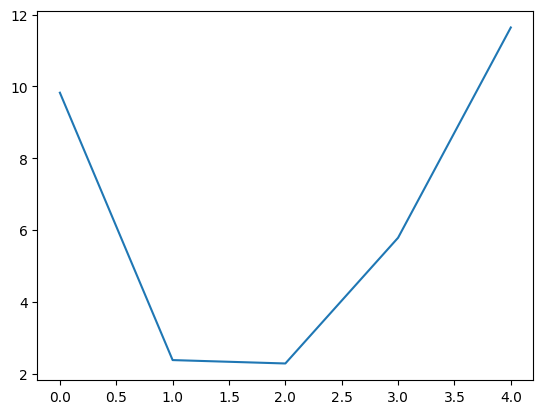

MSE, MAE and R2 : (0.40389790716050544, 1.6426356226866003, 0.6920283572980244)


In [113]:
#with l1
net_adam = MLP3(input_dim, hidden_dim, output_dim, activation, dropout_rate= 0)
criterion = nn.MSELoss()
optimizer_adam = optim.Adam(net_adam.parameters(), lr=learning_rate)

train_it(optimizer_adam, trainloader, net_adam, criterion, 20, 0.5)

print(f"MSE, MAE and R2 : {evaluate(net_adam, testloader)}")

Epoch 10 - Training loss: 17.596735382080077
Epoch 20 - Training loss: 14.069861698150635
Epoch 30 - Training loss: 12.434476852416992
Epoch 40 - Training loss: 12.217512702941894
Epoch 50 - Training loss: 11.388895320892335


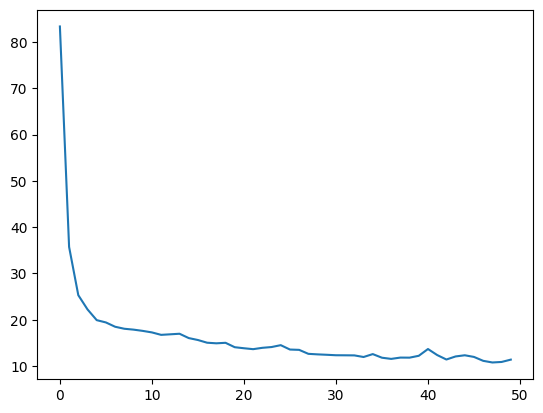

[0.24201285773486003, 0.6733478547878322, 0.3887568161545547, 0.7903687276538196, 0.4380388725199258]


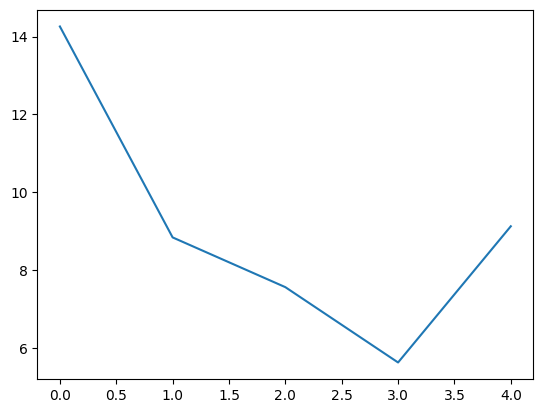

MSE, MAE and R2 : (0.574862323229826, 2.1728556797474243, 0.5570712456498771)


In [114]:
net_adam = MLP3(input_dim, hidden_dim, output_dim, activation, dropout_rate= 0)
criterion = nn.MSELoss()
optimizer_adam = optim.Adam(net_adam.parameters(), lr=learning_rate)


train_it(optimizer_adam, trainloader, net_adam, criterion, num_epochs = 50, l1 = 0.5)

print(f"MSE, MAE and R2 : {evaluate(net_adam, testloader)}")

Epoch 10 - Training loss: 3.0692451357841493
Epoch 20 - Training loss: 2.161066496372223
Epoch 30 - Training loss: 1.1061515510082245
Epoch 40 - Training loss: 0.9408126711845398
Epoch 50 - Training loss: 0.7466676414012909
Epoch 60 - Training loss: 1.1824729561805725
Epoch 70 - Training loss: 4.4544688820838925
Epoch 80 - Training loss: 0.7994354546070099
Epoch 90 - Training loss: 0.6690378069877625
Epoch 100 - Training loss: 0.5393114715814591


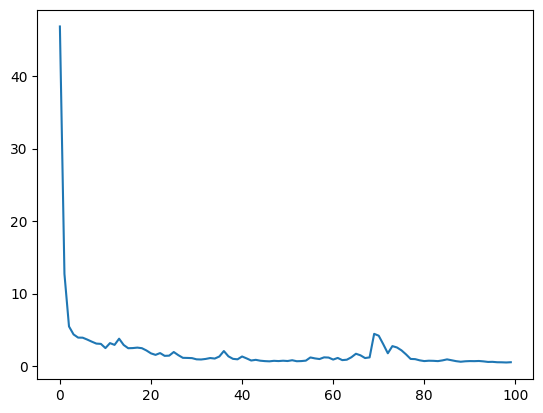

[0.5049538677203107, 0.8129042511420375, 0.7258430210937952, 0.5132941995255873, 0.13536517108110968]


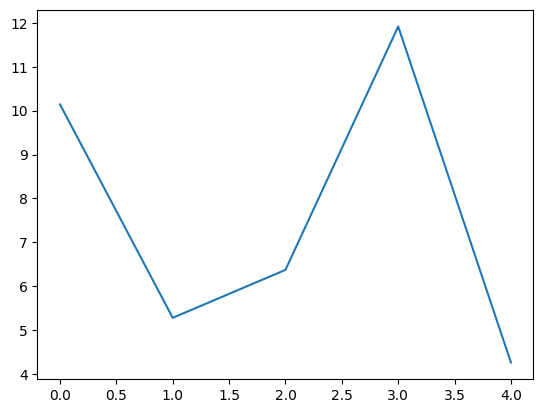

MSE, MAE and R2 : (0.4807545867147325, 1.6307209681106518, 0.6275024897604172)


In [95]:
net_adam = MLP3(input_dim, hidden_dim, output_dim, activation, dropout_rate= 0)
criterion = nn.MSELoss()
optimizer_adam = optim.Adam(net_adam.parameters(), lr=learning_rate)


train_it(optimizer_adam, trainloader, net_adam, criterion, num_epochs = 100, l1 = 0.01)
print(f"MSE, MAE and R2 : {evaluate(net_adam, testloader)}")

Epoch 10 - Training loss: 2.8521559476852416
Epoch 20 - Training loss: 1.3073064804077148
Epoch 30 - Training loss: 1.5375129997730255
Epoch 40 - Training loss: 0.4103843331336975
Epoch 50 - Training loss: 0.3350756987929344
Epoch 60 - Training loss: 0.5583511874079704
Epoch 70 - Training loss: 0.40666169077157976
Epoch 80 - Training loss: 0.3180770859122276
Epoch 90 - Training loss: 0.2433185949921608
Epoch 100 - Training loss: 0.14444573670625688


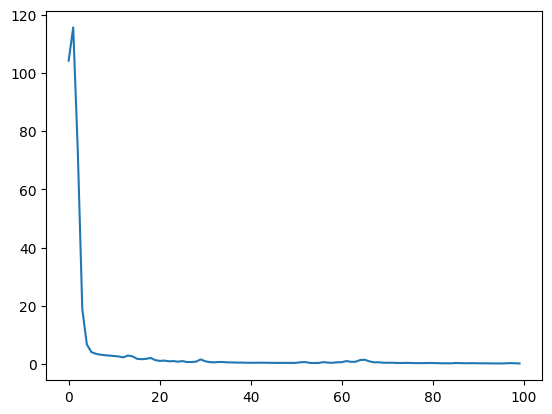

[0.4297673981083431, 0.5798273629355879, 0.7287838614449169, 0.47688723068822136, 0.9414594623582948]


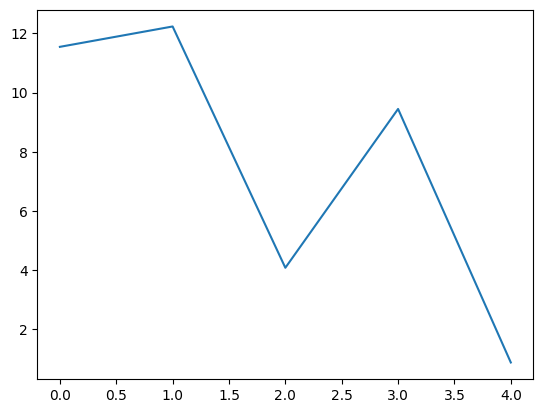

MSE, MAE and R2 : (0.48326684100718437, 1.6618428107681154, 0.6234476637553736)


In [96]:
net_adam = MLP3(input_dim, hidden_dim, output_dim, activation, dropout_rate= 0)
criterion = nn.MSELoss()
optimizer_adam = optim.Adam(net_adam.parameters(), lr=learning_rate)


train_it(optimizer_adam, trainloader, net_adam, criterion, num_epochs = 100)

print(f"MSE, MAE and R2 : {evaluate(net_adam, testloader)}")

# Ridge

Epoch 10 - Training loss: 3.4602528691291807
Epoch 20 - Training loss: 2.7665294408798218
Epoch 30 - Training loss: 2.750730222463608
Epoch 40 - Training loss: 1.6765755772590638
Epoch 50 - Training loss: 1.9815247356891632
Epoch 60 - Training loss: 1.457747495174408
Epoch 70 - Training loss: 2.8039677917957304
Epoch 80 - Training loss: 1.272050529718399
Epoch 90 - Training loss: 1.4169289141893386
Epoch 100 - Training loss: 0.9415004044771195


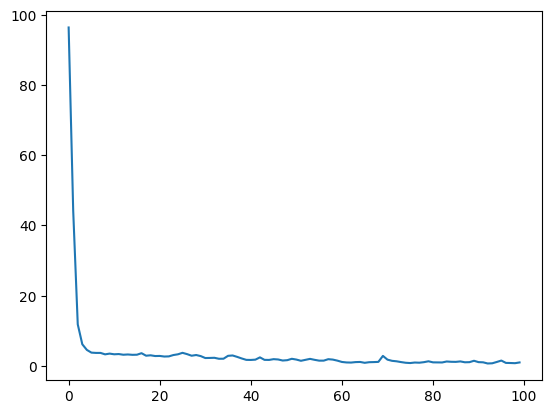

[0.41796512325884083, 0.9095726369205825, 0.5052686227192825, 0.5942194264405041, 0.6353759172550497]


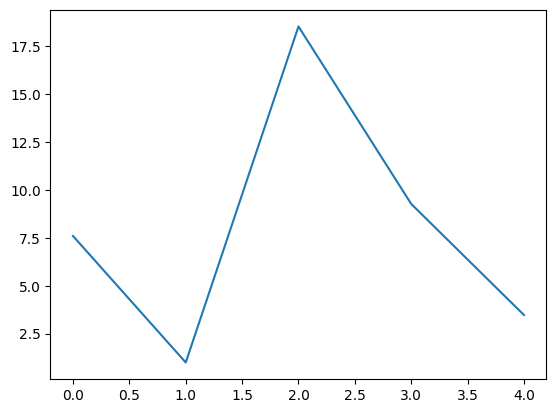

MSE, MAE and R2 : (0.5049227257318134, 1.7750572966812532, 0.6081558531978882)


In [116]:
net_adam = MLP3(input_dim, hidden_dim, output_dim, activation, dropout_rate= 0)
criterion = nn.MSELoss()
optimizer_adam = optim.Adam(net_adam.parameters(), lr=learning_rate, weight_decay=0.1)

train_it(optimizer_adam, trainloader, net_adam, criterion, num_epochs = 100)

print(f"MSE, MAE and R2 : {evaluate(net_adam, testloader)}")

Epoch 10 - Training loss: 5.190140581130981
Epoch 20 - Training loss: 5.510367202758789
Epoch 30 - Training loss: 4.5071035861969
Epoch 40 - Training loss: 4.578389716148377
Epoch 50 - Training loss: 5.295182108879089
Epoch 60 - Training loss: 4.944811153411865
Epoch 70 - Training loss: 5.18554835319519
Epoch 80 - Training loss: 4.635437273979187
Epoch 90 - Training loss: 4.211701142787933
Epoch 100 - Training loss: 4.831252145767212


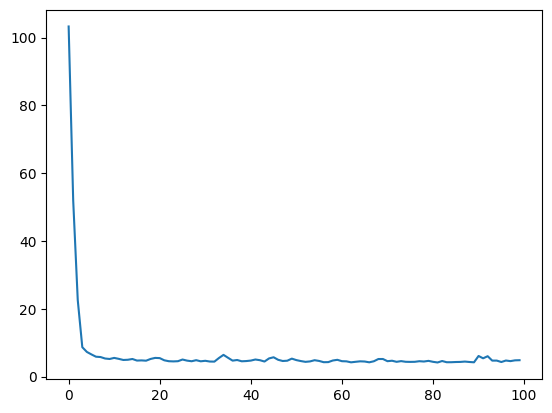

[0.46846224562327066, 0.8989492226339064, 0.7671537922163337, 0.6050909669452129, 0.7859449240834617]


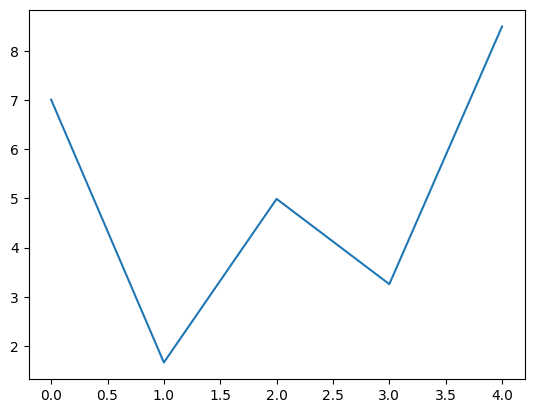

MSE, MAE and R2 : (0.3217427489123767, 1.3980671785052725, 0.754190062692102)


In [117]:
net_adam = MLP3(input_dim, hidden_dim, output_dim, activation, dropout_rate= 0)
criterion = nn.MSELoss()
optimizer_adam = optim.Adam(net_adam.parameters(), lr=learning_rate, weight_decay=0.5)

train_it(optimizer_adam, trainloader, net_adam, criterion, num_epochs = 100, l1 = 0.1)

print(f"MSE, MAE and R2 : {evaluate(net_adam, testloader)}")

  0%|          | 0/10 [00:00<?, ?it/s]

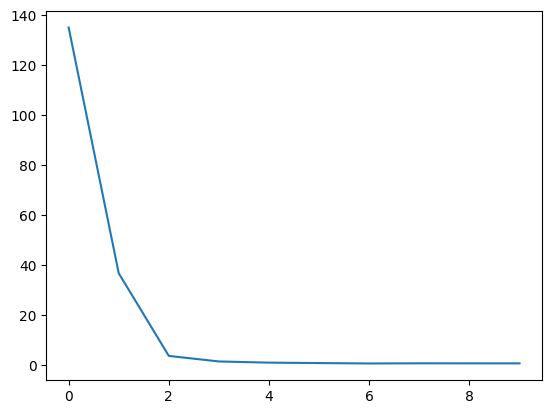

[0.8011054339233471, 0.7281642377034838, 0.7728318092986093, 0.9092771478016393, 0.6023533507299272]


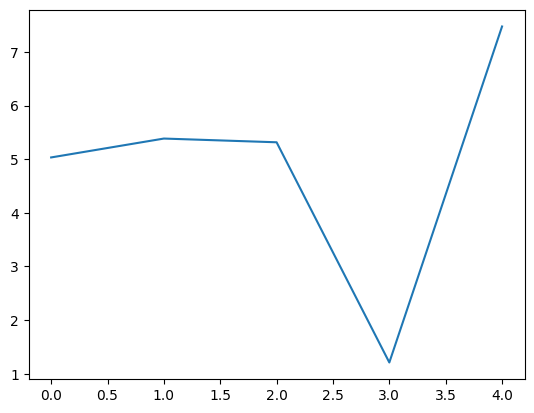

(0.3091359711900542, 1.2571600660493103, 0.7633974899408738)

In [118]:
net_adam = MLP3(input_dim, hidden_dim, output_dim, activation, dropout_rate= 0)
criterion = nn.MSELoss()
optimizer_adam = optim.Adam(net_adam.parameters(), lr=0.01)

batch_size = 16
num_epochs = 10
train_model(net_adam, optimizer_adam, trainset, batch_size, criterion, num_epochs, 50)

evaluate(net_adam, testloader)

Epoch 10 - Training loss: 4.993045735359192
Epoch 20 - Training loss: 3.797804093360901


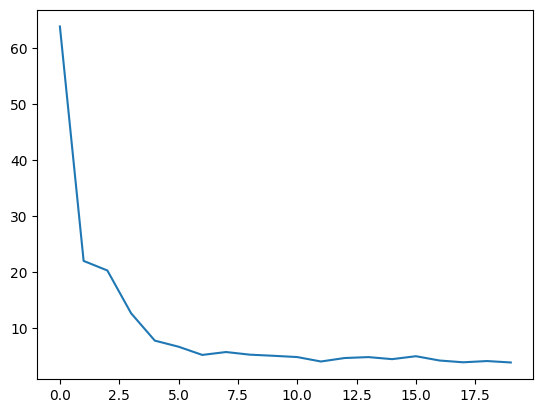

[0.8825358819753987, 0.7049867644541918, 0.571365987861772, 0.5090522763177896, 0.5523748215733659]


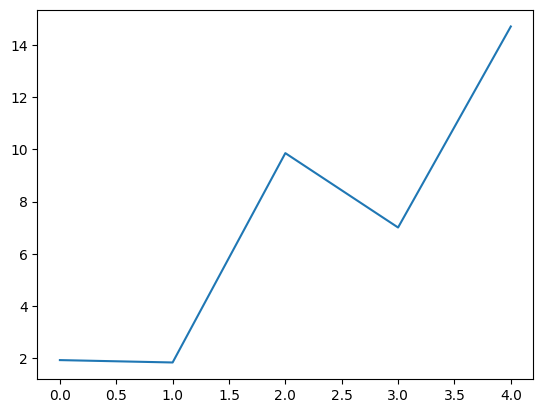

MSE, MAE and R2 : (0.4474373467360871, 1.7318709213522416, 0.6599473503904404)


In [119]:
net = MLP2(input_dim, hidden_dim, output_dim, nn.Tanh(), dropout_rate)
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
train_it(optimizer, trainloader, net, criterion, num_epochs=20)
print(f"MSE, MAE and R2 : {evaluate(net, testloader)}")

Epoch 10 - Training loss: 9.153206157684327
Epoch 20 - Training loss: 5.067746376991272


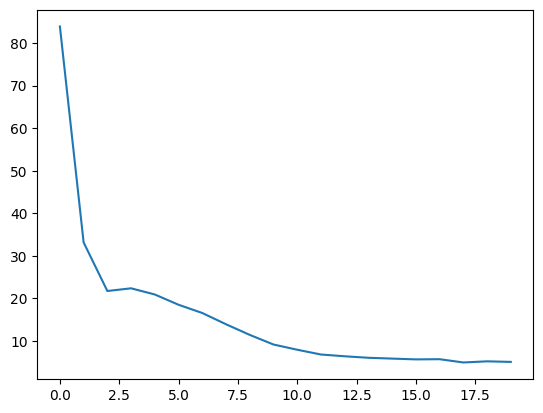

[0.8366404692303728, 0.46768075681987253, 0.875986590904172, 0.5823487809979793, 0.691120904732653]


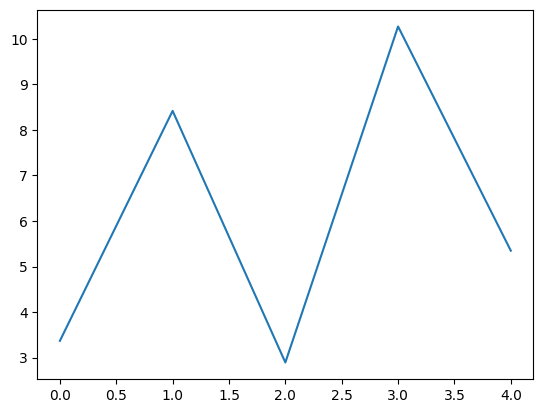

MSE, MAE and R2 : (0.383537120456937, 1.6980648070951052, 0.7040293236629402)


In [125]:
net = MLP2(input_dim, hidden_dim, output_dim, nn.Sigmoid(), dropout_rate)
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
train_it(optimizer, trainloader, net, criterion, num_epochs=20)
print(f"MSE, MAE and R2 : {evaluate(net, testloader)}")

Epoch 10 - Training loss: 4.411205244064331
Epoch 20 - Training loss: 3.656382989883423


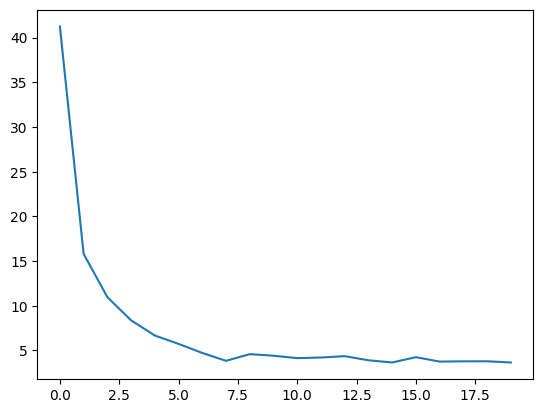

[0.7966918531188021, 0.7235115773162533, 0.6654079561285005, 0.36951386100716066, 0.6593851459842064]


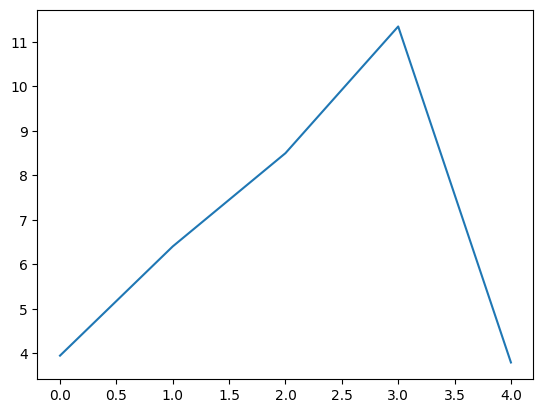

MSE, MAE and R2 : (0.4301879315436641, 1.9241573025908651, 0.6666662741878014)


In [123]:
net = MLP2(input_dim, hidden_dim, output_dim, nn.SELU(), dropout_rate)
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
train_it(optimizer, trainloader, net, criterion, num_epochs=20)
print(f"MSE, MAE and R2 : {evaluate(net, testloader)}")